## Loading packages, settings and eval data

In [1]:
import os
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as skm

from os import PathLike
from IPython.display import display
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpec
from pathlib import Path
from sklearn.metrics import ConfusionMatrixDisplay
from typing import cast, Tuple
from random import randint

from ba_dev.dataset import MammaliaDataSequence, MammaliaDataImage
from ba_dev.transform import ImagePipeline, BatchImagePipeline
from ba_dev.utils import load_path_yaml
from ba_dev.eval_helpers import *

set_custom_plot_style()
cm = 1 / 2.54

export = True

eval = MammaliaEval(
    path_config='../../data/path_config.yml',
    metrics=['balanced_accuracy_score'],
    force_metrics=False
    )

Loading pre-calculated metrics from file...


## Dataset analysis

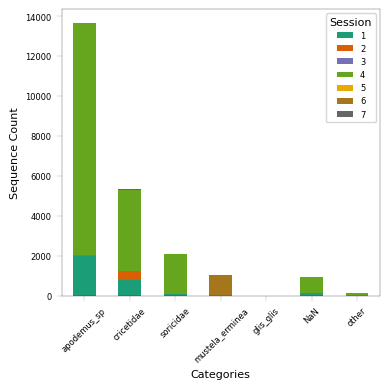

In [2]:
# Plot available Sequences per Label
########################################################################################################################
fig_name = "label2_session"
fig_size = (10*cm,10*cm)
########################################################################################################################

df = eval.raw_df.copy()

df["label2"] = df["label2"].fillna("NaN")

counts = df.groupby(["label2", "session"]).size().unstack(fill_value=0)
counts["total"] = counts.sum(axis=1)

special_labels = ["NaN", "other"]

regular = counts[~counts.index.isin(special_labels)].sort_values("total", ascending=False)
special = counts[counts.index.isin(special_labels)]

counts_sorted = pd.concat([regular, special])
counts_sorted = counts_sorted.drop(columns="total")

# Create figure
fig, ax = plt.subplots(figsize=(fig_size[0], fig_size[1]))

counts_sorted.plot(
    kind="bar",
    stacked=True,
    ax=ax,
    colormap="Dark2"
    )

ax.set_xlabel("Categories")
ax.set_ylabel("Sequence Count")
ax.tick_params(axis='x', rotation=45)
ax.legend(title="Session", loc='upper right')

plt.tight_layout()

if export:
    plt.savefig(eval.paths['figures'] / f'{fig_name}.pdf', dpi=300)

plt.show()

Sequences with n_files > 50: 2209 (9.51%)
Sequences with n_files > 100: 738 (3.18%)
Sequences with n_files > 200: 157 (0.68%)
Sequences with n_files > 500: 11 (0.05%)

Top 10 sequence lengths:
[915 741 738 684 675 612 612 579 558 546]


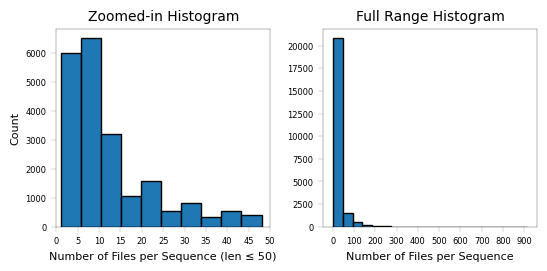

In [3]:
# Plot Histogram of Sequence Lengths
########################################################################################################################
fig_name = 'seq_len_histograms'
fig_size = (14*cm,7*cm)
########################################################################################################################

total_sequences = len(eval.raw_df.copy())

# Print percentage of sequences above each threshold
thresholds = [50, 100, 200, 500]
for t in thresholds:
    count = (df['n_files'] > t).sum()
    percent = count / total_sequences * 100
    print(f'Sequences with n_files > {t}: {count} ({percent:.2f}%)')

# Optionally, list the very largest sequence lengths
print('\nTop 10 sequence lengths:')
print(df['n_files'].nlargest(10).values)

plt.figure(figsize=fig_size)

ax1 = plt.subplot(1, 2, 1)
plt.hist(df['n_files'][df['n_files'] <= 50], bins=10, edgecolor='black')
plt.xlabel('Number of Files per Sequence (len ≤ 50)')
plt.ylabel('Count')
plt.title('Zoomed-in Histogram')
plt.xlim(0, 50)
ax1.set_xticks(np.arange(0, 51, 5))

# Right subplot: full range
ax2 = plt.subplot(1, 2, 2)
plt.hist(df['n_files'], bins=20, edgecolor='black')
plt.xlabel('Number of Files per Sequence')
plt.title('Full Range Histogram')
ax2.set_xticks(np.arange(0, 1000, 100))

plt.tight_layout()

if export:
    plt.savefig(eval.paths['figures'] / f'{fig_name}.pdf', dpi=300)

plt.show()
    

In [4]:
# Session info table
########################################################################################################################
table_name = 'session_info'
caption = r'Information about the origin of the different sessions in the dataset.'
########################################################################################################################

session_info = {
    1 : "Data from 'the wild', collected durch Wiesel&Co 2019",
    2 : "Data from 'the wild', collected during WILMA (SummerSchool) 2020",
    3 : "Data from 'the wild', collected by Vogelwarte 2020",
    4 : "Data from 'the wild', collected by WILMA (Bachelorthesis) 2020",
    5 : "Data from 'the wild', collected by WILMA (Roland) 2020 (Contains images and videos of stoats (Mustela erminea))",
    6 : "Data from an enclosure, collected by Nils (Contains only images of stoats (Mustela erminea))",
    7 : "Data gathered from Nathalie Straub in her Bachelor Thesis"
    }

session_desc = pd.DataFrame.from_dict(
    session_info, 
    orient='index', 
    columns=['description']
    ).reset_index().rename(columns={'index': 'session'})

latex_str = session_desc.to_latex(
    index=False,
    column_format='c p{12cm}',
    escape=True,
    header=['Session', 'Description'],
    caption=caption,
    label=f'tab:{table_name}'
    )

latex_str = place_table(latex_str, center=True, placement='H')

print(latex_str)

if export:
    with open(eval.paths['table'] / f'{table_name}.tex', 'w') as f:
        f.write(latex_str)


\begin{table}[H]
\centering
\caption{Information about the origin of the different sessions in the dataset.}
\label{tab:session_info}
\begin{tabular}{c p{12cm}}
\toprule
Session & Description \\
\midrule
1 & Data from 'the wild', collected durch Wiesel\&Co 2019 \\
2 & Data from 'the wild', collected during WILMA (SummerSchool) 2020 \\
3 & Data from 'the wild', collected by Vogelwarte 2020 \\
4 & Data from 'the wild', collected by WILMA (Bachelorthesis) 2020 \\
5 & Data from 'the wild', collected by WILMA (Roland) 2020 (Contains images and videos of stoats (Mustela erminea)) \\
6 & Data from an enclosure, collected by Nils (Contains only images of stoats (Mustela erminea)) \\
7 & Data gathered from Nathalie Straub in her Bachelor Thesis \\
\bottomrule
\end{tabular}
\end{table}


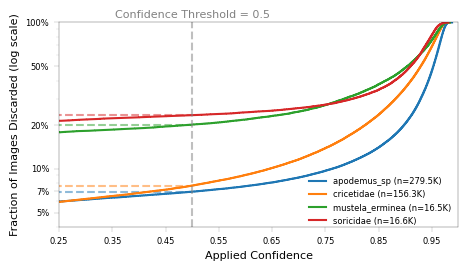

In [5]:
# Plot Fraction of Discarded Images by Applied Confidence
########################################################################################################################
fig_name = 'discarded_img_by_conf'
fig_size = (12*cm,7*cm)
conf_threshold = 0.5
########################################################################################################################

df = eval.image_df.copy()

cdf_data = (
    df.sort_values(by='conf')
      .groupby('class_label', group_keys=False)
      .apply(lambda g: pd.DataFrame({
          'conf': np.sort(g['conf'].to_numpy()),
          'cum_density': np.linspace(0, 1, len(g)),
          'class_label': g.name  # this is the current group label
      }), include_groups=False)
      .reset_index(drop=True)
)

# Plotting
class_counts = df['class_label'].value_counts().to_dict()

plt.figure(figsize=fig_size)
for class_label, group in cdf_data.groupby('class_label'):
    count = class_counts.get(class_label, 0)
    label = f'{class_label} (n={count/1000:.1f}K)'
    
    line, = plt.plot(group['conf'], group['cum_density'], label=label)

    above_thresh = group[group['conf'] >= conf_threshold]
    if not above_thresh.empty:
        y_at_thresh = above_thresh['cum_density'].iloc[0]
        plt.hlines(y=y_at_thresh, xmin=0.24, xmax=conf_threshold, linestyle='--', alpha=0.5, color=line.get_color())

plt.axvline(x=conf_threshold, linestyle='--', color='gray', alpha=0.5)
plt.text(
    x=conf_threshold, y=1.08,
    s=f'Confidence Threshold = {conf_threshold}',
    horizontalalignment='center',
    fontsize=8,
    color='gray'
)

plt.xlabel('Applied Confidence')
plt.ylabel('Fraction of Images Discarded (log scale)')
plt.yscale('log')
plt.yticks(
    [0.05, 0.07, 0.1, 0.2, 0.5, 1], 
    labels=['5%', '7%', '10%', '20%', '50%', '100%']
    )
plt.xticks(
    np.arange(0.25, 1, 0.1),
    labels=[f'{x:.2f}' for x in np.arange(0.25, 1, 0.1)]
)
plt.legend(
    loc='lower right',
    bbox_to_anchor=(1, -0.03),
    frameon=False
)
plt.xlim(left=0.25, right=1)
plt.ylim(bottom=0.04, top=1)
plt.tight_layout()

if export:
    plt.savefig(eval.paths['figures'] / f'{fig_name}.pdf', dpi=300)
    
plt.show()

In [6]:
# MD output - data available
########################################################################################################################
table_name = 'data_availability_after_md'
caption = r'Data loss dew to MD output for confidence thresholds of 0.25 and 0.5 by category.'
########################################################################################################################

df_seq = count_vs_threshold(eval.sequence_df.copy(), thresholds=[0.25, 0.5], base_name="seq")
df_img = count_vs_threshold(eval.image_df.copy(), thresholds=[0.25, 0.5], base_name="img")
joined_df = df_seq.merge(df_img, on='class_label')

keys = joined_df.keys()

lines = [
        '\\begin{table}',
        f'\\caption{{{caption}}}',
        f'\\label{{tab:{table_name}}}',
        '\\begin{tabular}{l r r r r}',
        '\\toprule'
        ]

last = 'first'
key_l = ''
treshold = '0'

for key in keys:

    info = key.split('_')

    if info[0] != last:
        
        if info[0] == 'seq':
            lines.append('\midrule')
            lines.append('\\textbf{Sequence Level} & & & & \\\\')
        elif info[0] == 'img':
            lines.append('\midrule')
            lines.append('\midrule')
            lines.append('\\textbf{Image Level} & & & & \\\\')
        
    last = info[0]
    
    if len(info) == 2:
        key_l = 'Total available'
    elif len(info) == 3:
        if info[2] != treshold:
            lines.append('\midrule')
            lines.append(f'Threshold of {info[2]}: & & & & \\\\')
            treshold = info[2]

        if info[1] == 'lost':
            key_l = 'Lost'
        elif info[1] == 'frac':
            key_l = 'Fraction lost'
        elif info[1] == 'avail':
            key_l = 'Available'


    data = joined_df[key].values

    data_str = ''

    for value in data:
        if isinstance(value, str):
            value = value.replace('_', '\_')
            key_l = ''
        else:
            value = str(value)
        
        data_str += ' & ' + value

    new_line = key_l + data_str + ' \\\\'
    lines.append(new_line)

lines.extend([
    '\\bottomrule',
    '\\end{tabular}',
    '\\end{table}'
    ])

latex = "\n".join(lines)
latex = place_table(latex, center=True, placement='H')

print(latex)

if export:
    with open(eval.paths['table'] / f'{table_name}.tex', 'w') as f:
        f.write(latex)

\begin{table}[H]
\centering
\caption{Data loss dew to MD output for confidence thresholds of 0.25 and 0.5 by category.}
\label{tab:data_availability_after_md}
\begin{tabular}{l r r r r}
\toprule
 & apodemus\_sp & cricetidae & mustela\_erminea & soricidae \\
\midrule
\textbf{Sequence Level} & & & & \\
Total available & 13669 & 5329 & 1035 & 2107 \\
\midrule
Threshold of 0.25: & & & & \\
Lost & 51 & 40 & 211 & 7 \\
Fraction lost & 0.0 & 0.01 & 0.2 & 0.0 \\
Available & 13618 & 5289 & 824 & 2100 \\
\midrule
Threshold of 0.5: & & & & \\
Lost & 56 & 46 & 239 & 13 \\
Fraction lost & 0.0 & 0.01 & 0.23 & 0.01 \\
Available & 13613 & 5283 & 796 & 2094 \\
\midrule
\midrule
\textbf{Image Level} & & & & \\
Total available & 279492 & 156350 & 16465 & 16645 \\
\midrule
Threshold of 0.25: & & & & \\
Lost & 16609 & 9248 & 2914 & 3529 \\
Fraction lost & 0.06 & 0.06 & 0.18 & 0.21 \\
Available & 262883 & 147102 & 13551 & 13116 \\
\midrule
Threshold of 0.5: & & & & \\
Lost & 19417 & 11948 & 3290 & 3865 \\
F

/Users/jk/MyPythonPackages/BA_package/ba_dev/dataset.py:249: UserWarning: With the detection confidence of 0.25,
309 sequences had no detections and will be excluded.
Excluded sequences: [6000646, 6000663, 6000665, 6000679, 6000680, 6000681, 6000683, 4001841, 1001523, 6000691] ...
  warnings.warn(


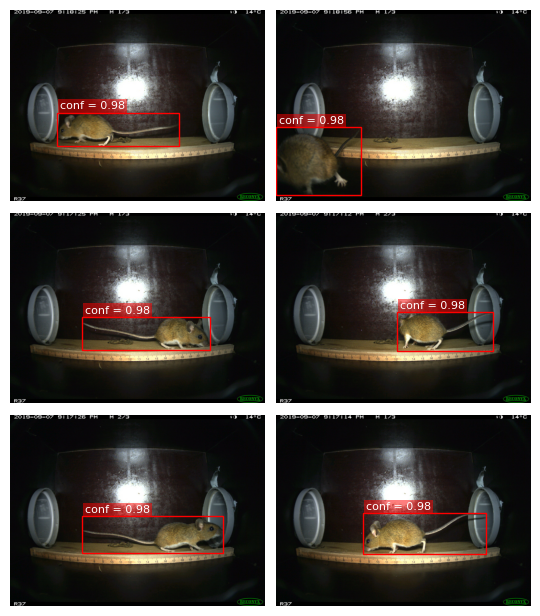

In [7]:
# Detections of a Sequence
########################################################################################################################
fig_name = 'detections_on_a_sequence'
fig_width = 14*cm
seq_id = 1001824
scaling_factor = 0.5
########################################################################################################################


dataset_seq = MammaliaDataSequence(
    path_labelfiles=eval.paths['labels'],
    path_to_dataset=eval.paths['dataset'],
    path_to_detector_output=eval.paths['md_output'],
    detector_model=None,
    mode='eval'
    )

i = dataset_seq.get_index_by_seq_id(seq_id)
sequence = dataset_seq[i]

length = len(sequence['sample'])

if length >= 6:
    nrows = 3
    ncols = 2
else:
    raise ValueError("The sequence is too short to be displayed in a 3x2 grid.")

fig = plt.figure(figsize=(fig_width, fig_width * nrows / ncols * 3/4))
gs = GridSpec(
    nrows=nrows, ncols=ncols,
    figure=fig,
    )

for col in range(ncols):
    for row in range(nrows):
        ax = fig.add_subplot(gs[row, col])

        if col == 0:
            idx = row
        else:
            idx = -(nrows - row)

        sample = {
            'img': sequence['sample'][idx],
            'bbox': sequence['bbox'][idx],
            'conf': sequence['conf'][idx]
            }

        draw_bbox_on_ax(ax, sample)

fig.tight_layout()

if export:
    plt.savefig(eval.paths['figures'] / f'{fig_name}.pdf', dpi=300)
    
plt.show()

## Model analysis

### Balanced Accuracy of all Models

In [8]:
# Balanced accuracy Table for all models
########################################################################################################################
table_name = 'bal_acc_by_model'
caption = r'Balanced accuracy of all models -- shown as mean ± standard deviation.'
########################################################################################################################

summary_bal_acc = (
    eval.metrics_df.copy()
    .loc[eval.metrics_df['metric'] == 'balanced_accuracy_score']
    .groupby(['model_name', 'pretrained'])
    .agg(
        trainable_params=('trainable_params', 'first'),
        img_score_mean=('img_score', 'mean'),
        img_score_std =('img_score', 'std'),
        seq_score_mean=('seq_score', 'mean'),
        seq_score_std =('seq_score', 'std'),
    )
    .reset_index()
    .sort_values(
        by=['pretrained', 'trainable_params'],
        ascending=[False, True]
    )
    )

for scope in ['img', 'seq']:
    mean_str = summary_bal_acc[f'{scope}_score_mean'].map("{:.4f}".format)
    std_str  = summary_bal_acc[f'{scope}_score_std'].map("{:.3f}".format)
    summary_bal_acc[f'bal_acc_{scope}'] = mean_str + ' ± ' + std_str

table = (
        summary_bal_acc[
            ['model_name', 'pretrained', 'trainable_params', 'bal_acc_img', 'bal_acc_seq']
        ]
        .rename(columns={
            'model_name': 'Model',
            'pretrained': 'Pretrained',
            'trainable_params': 'Params (M)',
            'bal_acc_img': r'Image BA-Score',
            'bal_acc_seq': r'Sequence BA-Score'
        }))

table['Params (M)'] = (table['Params (M)'] / 1_000_000).astype(int)
table['Pretrained'] = table['Pretrained'].map({True: 'Yes', False: 'No'})

latex = table.to_latex(
    index=False,
    column_format='l c r c c',
    escape=True,
    caption=caption,
    label=f'tab:{table_name}',
    )

lines = latex.splitlines()

for i, line in enumerate(lines):
    if '& No &' in line:
        split_index = i
        break

new_lines = lines[:split_index] + ['\midrule'] + lines[split_index:]

latex = "\n".join(new_lines)

latex = place_table(latex, center=True, placement='H')

print(latex)

if export:
    with open(eval.paths['table'] / f'{table_name}.tex', 'w') as f:
        f.write(latex)


\begin{table}[H]
\centering
\caption{Balanced accuracy of all models -- shown as mean ± standard deviation.}
\label{tab:bal_acc_by_model}
\begin{tabular}{l c r c c}
\toprule
Model & Pretrained & Params (M) & Image BA-Score & Sequence BA-Score \\
\midrule
efficientnet\_b0 & Yes & 4 & 0.9921 ± 0.004 & 0.9947 ± 0.002 \\
densenet169 & Yes & 12 & 0.9904 ± 0.004 & 0.9939 ± 0.002 \\
resnet50 & Yes & 23 & 0.9899 ± 0.004 & 0.9934 ± 0.002 \\
vit\_b\_16 & Yes & 85 & 0.9885 ± 0.005 & 0.9933 ± 0.002 \\
\midrule
efficientnet\_b0 & No & 4 & 0.9856 ± 0.005 & 0.9898 ± 0.003 \\
densenet169 & No & 12 & 0.9863 ± 0.006 & 0.9899 ± 0.002 \\
resnet50 & No & 23 & 0.9850 ± 0.004 & 0.9888 ± 0.003 \\
vit\_b\_16 & No & 85 & 0.9767 ± 0.006 & 0.9856 ± 0.004 \\
\bottomrule
\end{tabular}
\end{table}


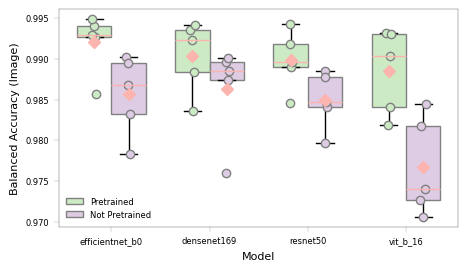

In [9]:
# Box Plot for Balanced Accuracy by Model and Pretrained Status
########################################################################################################################
fig_name = 'bal_acc_img'
fig_size = (12*cm,7*cm)
########################################################################################################################

bal_acc = (
    eval.metrics_df.copy()
    .loc[eval.metrics_df['metric'] == 'balanced_accuracy_score']
    )

models = ['efficientnet_b0', 'densenet169','resnet50', 'vit_b_16']
n = len(models)
x = range(n)
width = 0.35

data_pre = [
    bal_acc[(bal_acc['model_name']==m) & (bal_acc['pretrained'])]['img_score'] 
    for m in models
    ]
data_no = [
    bal_acc[(bal_acc['model_name']==m) & (~bal_acc['pretrained'])]['img_score'] 
    for m in models
    ]

cmap = plt.get_cmap('Pastel1')
color_pre = cmap(2)
color_no  = cmap(3)
red = cmap(0)

plt.figure(figsize=fig_size)

medianprops = dict(linewidth=1, color=red)

meanprops = dict(
                marker='D',
                markeredgecolor=red,
                markerfacecolor=red,
                markersize=6
                )

flierprops = dict(marker='', linestyle='none')

bp_pre = plt.boxplot(
    data_pre,
    positions=[i - width/2 for i in x],
    widths=width,
    patch_artist=True,
    manage_ticks=False,
    showmeans=True,
    meanprops=meanprops,
    medianprops=medianprops,
    flierprops=flierprops
    )
bp_no = plt.boxplot(
    data_no,
    positions=[i + width/2 for i in x],
    widths=width,
    patch_artist=True,
    manage_ticks=False,
    showmeans=True,
    meanprops=meanprops,
    medianprops=medianprops,
    flierprops=flierprops
    )

for box in bp_pre['boxes']:
    box.set_facecolor(color_pre)
    box.set_edgecolor('gray')
for box in bp_no['boxes']:
    box.set_facecolor(color_no)
    box.set_edgecolor('gray')

plt.xticks(x, models, ha='center')
plt.xlabel('Model')
plt.ylabel('Balanced Accuracy (Image)')

legend_handles = [
    Patch(facecolor=color_pre, edgecolor='gray', label='Pretrained'),
    Patch(facecolor=color_no,  edgecolor='gray', label='Not Pretrained')
    ]
plt.legend(handles=legend_handles, frameon=False, loc='lower left')

for i, m in enumerate(models):
    y_pre = bal_acc[(bal_acc['model_name']==m) & (bal_acc['pretrained'])]['img_score']
    x_pre = np.random.normal(i - width/2, width*0.05, size=len(y_pre))
    plt.scatter(x_pre, y_pre, color=color_pre, edgecolor='gray', zorder=2)

    y_no  = bal_acc[(bal_acc['model_name']==m) & (~bal_acc['pretrained'])]['img_score']
    x_no  = np.random.normal(i + width/2, width*0.05, size=len(y_no))
    plt.scatter(x_no, y_no, color=color_no,  edgecolor='gray', zorder=2)


plt.tight_layout()

if export:
    plt.savefig(eval.paths['figures'] / f'{fig_name}.pdf', dpi=300)
plt.show()

### Performance of Best Model

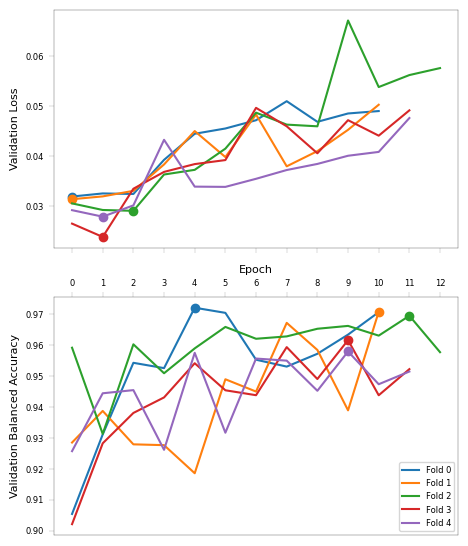

In [10]:
# Training metrics for best model
########################################################################################################################
fig_name = 'training_metrics_best_model'
fig_size = (12*cm, 14*cm)
########################################################################################################################

def process_metrics(df: pd.DataFrame) -> pd.DataFrame:
    return (
        df
        .loc[:, ['epoch'] + [col for col in df.columns if col.startswith('val_')]]
        .pipe(lambda d: d.dropna(subset=[col for col in d.columns if col != 'epoch'], how='all'))
        .assign(epoch=lambda d: d['epoch'].astype(int))
        )

train_metrics = eval.best_model.get_training_metrics(process=process_metrics).copy()

fig, axes = plt.subplots(2, 1, figsize=fig_size, sharex=True)

# Titles and y-axis labels for both plots
metrics = ['val_loss','val_bal_acc']
ylabels = ['Validation Loss', 'Validation Balanced Accuracy']

all_epochs = sorted(set().union(*[df['epoch'] for df in train_metrics]))

for i, metric in enumerate(metrics):
    ax = axes[i]
    for fold_idx, df in enumerate(train_metrics):
        # Plot the line and capture the Line2D object to get the color
        line, = ax.plot(df['epoch'], df[metric], label=f'Fold {fold_idx}')
        color = line.get_color()

        # Find best point: min for loss, max for balanced accuracy
        if metric == 'val_loss':
            idx = df[metric].idxmin()
        else:  # 'val_bal_acc'
            idx = df[metric].idxmax()

        best_epoch = df.loc[idx, 'epoch']
        best_value = df.loc[idx, metric]

        # Highlight point using same color
        ax.plot(best_epoch, best_value, 'o', color=color)

    ax.set_ylabel(ylabels[i])
    ax.set_xticks(all_epochs)

    if i == 1:
        ax.legend()
        ax.set_xlabel('Epoch')
        ax.xaxis.set_ticks_position('top')
        ax.xaxis.set_label_position('top')

plt.tight_layout()
if export:
        plt.savefig(eval.paths['figures'] / f'{fig_name}.pdf', dpi=300)
plt.show()

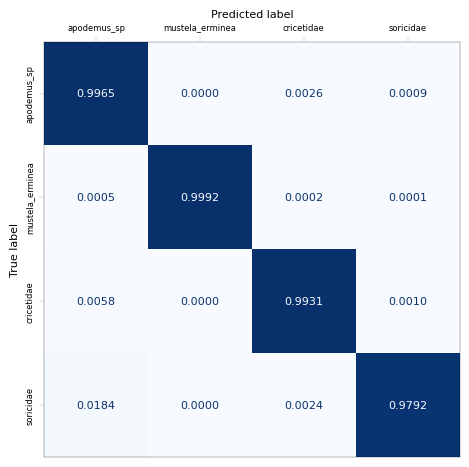

In [11]:
# Confusion Matrix for the best model
########################################################################################################################
fig_name = 'conf_matrix_best'
fig_size = (12*cm,12*cm)
########################################################################################################################

df = eval.best_model.full_predicted_set.copy()

y_true = df['class_id'].to_list()
y_pred = df['pred_id'].to_list()

labels = list(eval.best_model.decoder.values())

confusion_matrix = skm.confusion_matrix(
    y_true,
    y_pred,
    labels=list(eval.best_model.decoder.keys()),
    normalize='true'
    )

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,
                              display_labels=labels)
fig, ax = plt.subplots(figsize=fig_size)
disp.plot(
    ax=ax,
    cmap='Blues',
    colorbar=False,
    values_format='.4f'
    )

n = len(labels)
ax.set_xticks(np.arange(n))
ax.set_yticks(np.arange(n))
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
plt.xticks(rotation=0, ha='center')
plt.yticks(rotation=90, va='center')

plt.tight_layout()
if export:
        plt.savefig(eval.paths['figures'] / f'{fig_name}.pdf', dpi=300)
plt.show()

In [12]:
# Precision, Recall and F1-Score for the best model
########################################################################################################################
table_name = 'precision_recall_fscore_support'
caption = r'Class-wise precision, recall, F1-score, and support for the best-performing model.'
########################################################################################################################

df = eval.best_model.full_predicted_set.copy()

y_true = df['class_id'].to_list()
y_pred = df['pred_id'].to_list()

labels_ids = [k for k in eval.best_model.decoder]

result  = skm.precision_recall_fscore_support(
    y_true,
    y_pred,
    labels=list(eval.best_model.decoder.keys()),
    zero_division=0
    )

precision, recall, f1_score, support = cast(
    Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray],
    result
    )

data = []
for i, label in enumerate(list(eval.best_model.decoder.values())):
    data.append({
        'Class'    : label,
        'Precision': precision[i],
        'Recall'   : recall[i],
        'F1-Score' : f1_score[i],
        'Support'  : int(support[i]),
    })

df = pd.DataFrame(data)

latex = df.to_latex(
    index=False,
    column_format='l r r r r',
    escape=True,
    float_format="%.3f",
    caption=caption,
    label=f'tab:{table_name}',
    )

latex = place_table(latex, center=True, placement='H')

print(latex)

if export:
    with open(eval.paths['table'] / f'{table_name}.tex', 'w') as f:
        f.write(latex)


\begin{table}[H]
\centering
\caption{Class-wise precision, recall, F1-score, and support for the best-performing model.}
\label{tab:precision_recall_fscore_support}
\begin{tabular}{l r r r r}
\toprule
Class & Precision & Recall & F1-Score & Support \\
\midrule
apodemus\_sp & 0.996 & 0.997 & 0.996 & 260075 \\
mustela\_erminea & 0.999 & 0.999 & 0.999 & 13175 \\
cricetidae & 0.995 & 0.993 & 0.994 & 144402 \\
soricidae & 0.971 & 0.979 & 0.975 & 12780 \\
\bottomrule
\end{tabular}
\end{table}


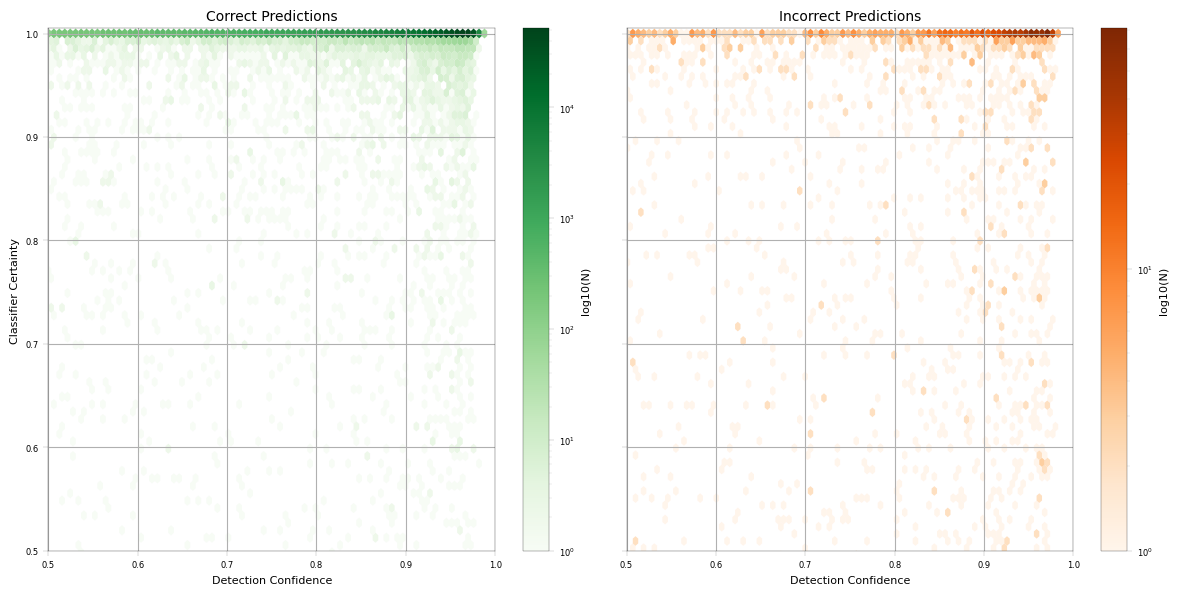

In [13]:
# Prediction and Detection Confidence Hexbin Plot of Correct and Incorrect Predictions
########################################################################################################################
fig_name = 'pred_conf_hexbin'
########################################################################################################################

df = eval.best_model.full_predicted_set.copy()

df_correct = df[df['correct'] == True]
df_incorrect = df[df['correct'] == False]

gridsize = 80
linewidths = 0.01
mincnt = 0 

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

hb1 = axes[0].hexbin(
    df_correct['conf'], df_correct['probs_max'],
    gridsize=gridsize, mincnt=mincnt, cmap='Greens', bins='log', linewidths=linewidths
)
axes[0].set_title('Correct Predictions')
axes[0].set_xlabel('Detection Confidence')
axes[0].set_ylabel('Classifier Certainty')

hb2 = axes[1].hexbin(
    df_incorrect['conf'], df_incorrect['probs_max'],
    gridsize=gridsize, mincnt=mincnt, cmap='Oranges', bins='log', linewidths=linewidths
)
axes[1].set_title('Incorrect Predictions')
axes[1].set_xlabel('Detection Confidence')

for ax in axes:
    ax.grid(True)
    ax.set_xlim(0.5, 1)
    ax.set_ylim(0.5, 1.005)

fig.colorbar(hb1, ax=axes[0], orientation='vertical', label='log10(N)')
fig.colorbar(hb2, ax=axes[1], orientation='vertical', label='log10(N)')

plt.tight_layout()
export = True
if export:
        plt.savefig(eval.paths['figures'] / f'{fig_name}.pdf', dpi=300)
plt.show()

## Visual inspection of Detection

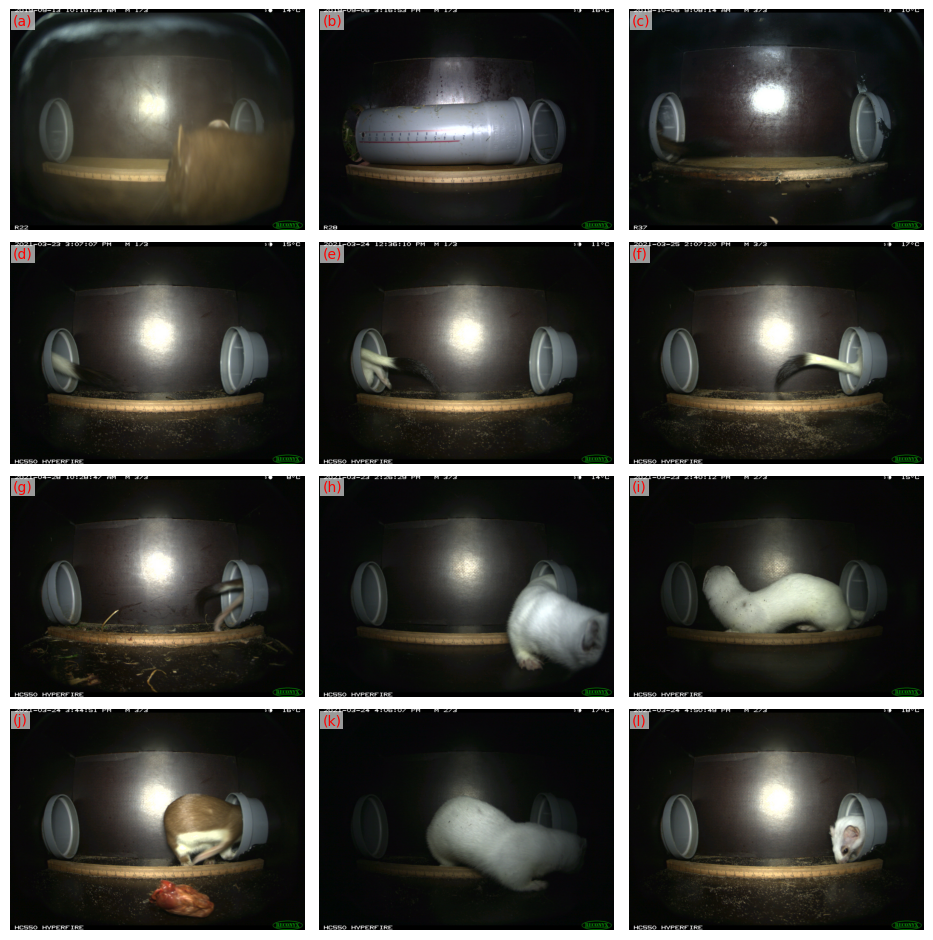

In [14]:
# Visual of Mustela erminea with no detections
########################################################################################################################
fig_name = 'mustela_special_nodetect'
########################################################################################################################
image_df=eval.image_df.copy()

mustela_erminea_nodetect = [22374, 35835, 33248, 421320, 421394, 421465, 421507, 421590, 421664, 421712, 421959, 423864]
order = [0, 1, 2, 5, 6, 10, 11, 3, 4, 7, 8, 9]
mustela_erminea_nodetect = [mustela_erminea_nodetect[i] for i in order]

filtered_image_df = image_df.loc[mustela_erminea_nodetect]

fig = plot_series_of_images(
    df=filtered_image_df, 
    dataset_path=eval.paths['dataset'], 
    ncols=3, 
    fig_width_cm=24,
    offset_margin_conf_annotation=800
    )

if export:
    fig.savefig(eval.paths['figures'] / f'{fig_name}.pdf', dpi=300)
    
display(fig)

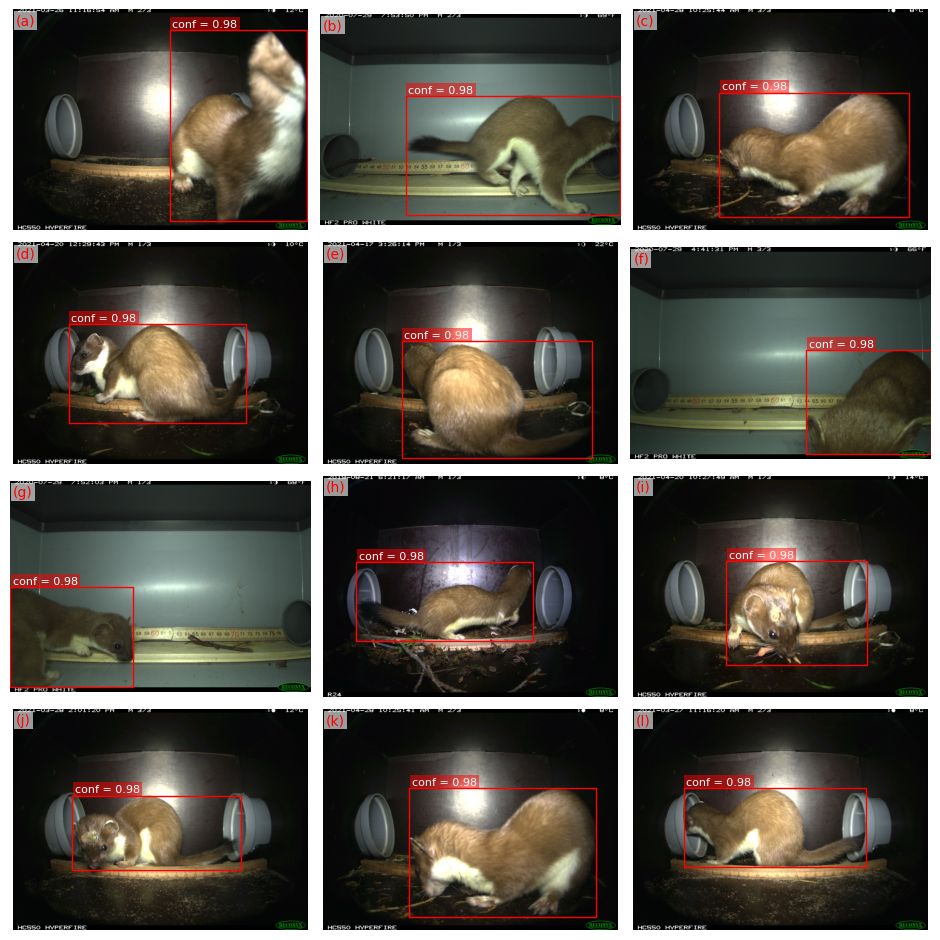

In [15]:
# Visual of Mustela erminea best detections
########################################################################################################################
fig_name = 'mustela_best'
start_id = 0
end_id = 12
########################################################################################################################
image_df = eval.image_df.copy()

filter = (image_df["conf"] >= 0.5) & (image_df["class_label"] == "mustela_erminea")
filtered_image_df = image_df.where(filter).dropna().sort_values(by='conf', ascending=False)
selected_df = filtered_image_df.iloc[start_id:end_id]

fig = plot_series_of_images(
    df=selected_df, 
    dataset_path=eval.paths['dataset'], 
    ncols=3, 
    fig_width_cm=24,
    offset_margin_conf_annotation=800
    )

if export:
    fig.savefig(eval.paths['figures'] / f'{fig_name}.pdf', dpi=300)
    
display(fig)

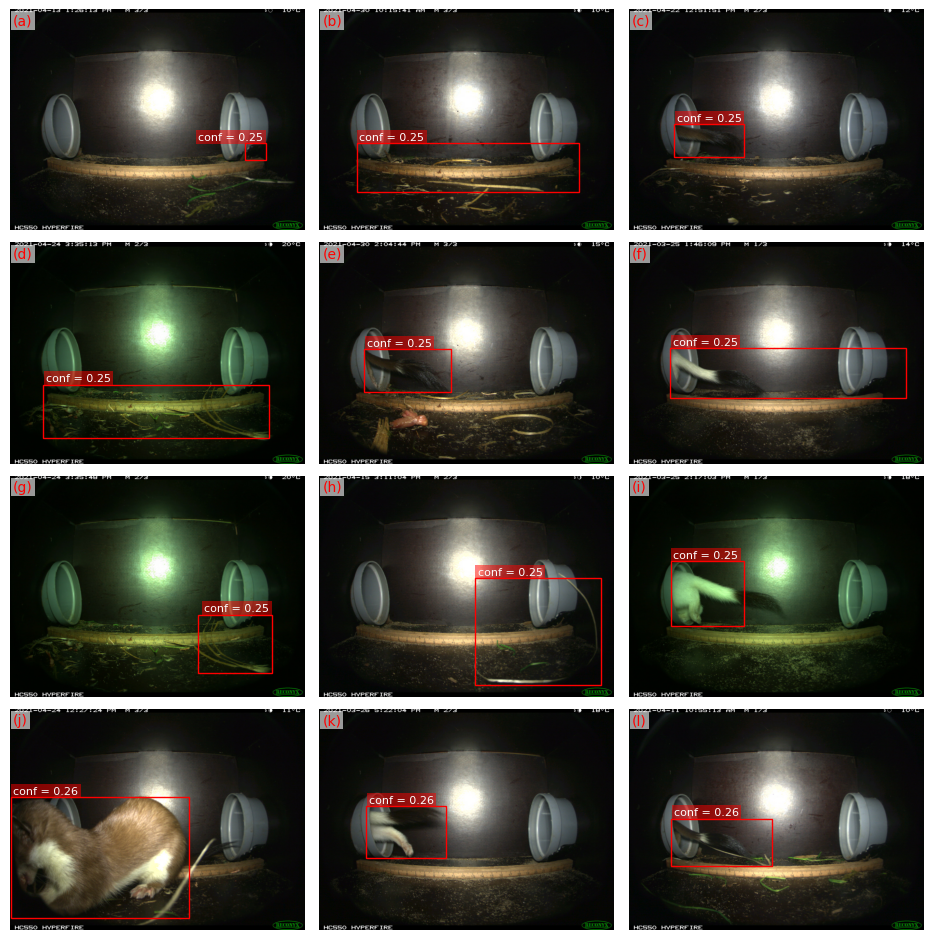

In [16]:
# Visual of Mustela erminea detection confidence just above 0.25
########################################################################################################################
fig_name = 'mustela_just_above25'
start_id = 0
end_id = 12
########################################################################################################################
image_df = eval.image_df.copy()

filter = (image_df["conf"] >= 0.25) & (image_df["class_label"] == "mustela_erminea")
filtered_image_df = image_df.where(filter).dropna().sort_values(by='conf', ascending=True)
selected_df = filtered_image_df.iloc[start_id:end_id]

fig = plot_series_of_images(
    df=selected_df, 
    dataset_path=eval.paths['dataset'], 
    ncols=3, 
    fig_width_cm=24,
    offset_margin_conf_annotation=800
    )

if export:
    fig.savefig(eval.paths['figures'] / f'{fig_name}.pdf', dpi=300)
    
display(fig)

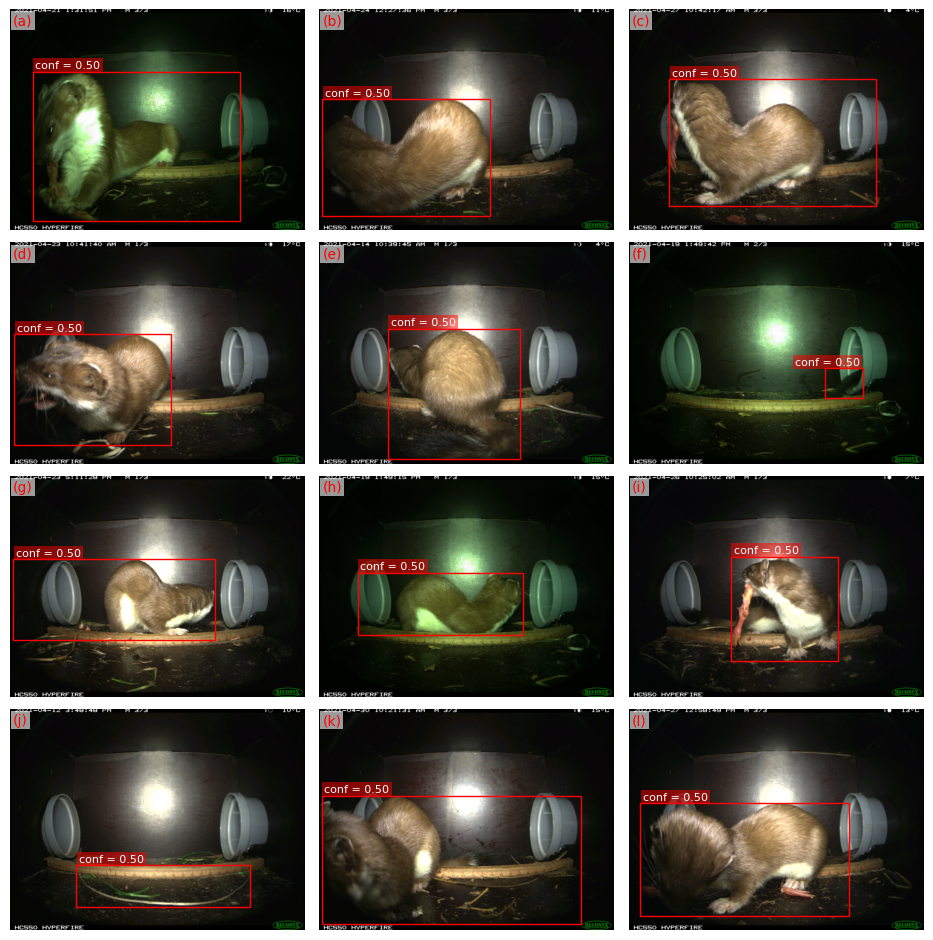

In [17]:
# Visual of Mustela erminea detection confidence just above 0.5
########################################################################################################################
fig_name = 'mustela_just_above5'
start_id = 0
end_id = 12
########################################################################################################################
image_df = eval.image_df.copy()

filter = (image_df["conf"] >= 0.5) & (image_df["class_label"] == "mustela_erminea")
filtered_image_df = image_df.where(filter).dropna().sort_values(by='conf', ascending=True)
selected_df = filtered_image_df.iloc[start_id:end_id]

fig = plot_series_of_images(
    df=selected_df, 
    dataset_path=eval.paths['dataset'], 
    ncols=3, 
    fig_width_cm=24,
    offset_margin_conf_annotation=800
    )

if export:
    fig.savefig(eval.paths['figures'] / f'{fig_name}.pdf', dpi=300)
    
display(fig)

## Visual inspection of Detection

## Brows trough ds

In [18]:
df = eval.best_model.full_predicted_set.copy()

df_filtered = (
    df
    .query('correct == False')
    .sort_values('probs_max', ascending=False)
    )

chunker = DFChunker(df_filtered, chunk_size=12)

DataFrame has 2174 rows,
will be split into 182 chunks of size 12.


Showing chunk 1 of 182 chunks


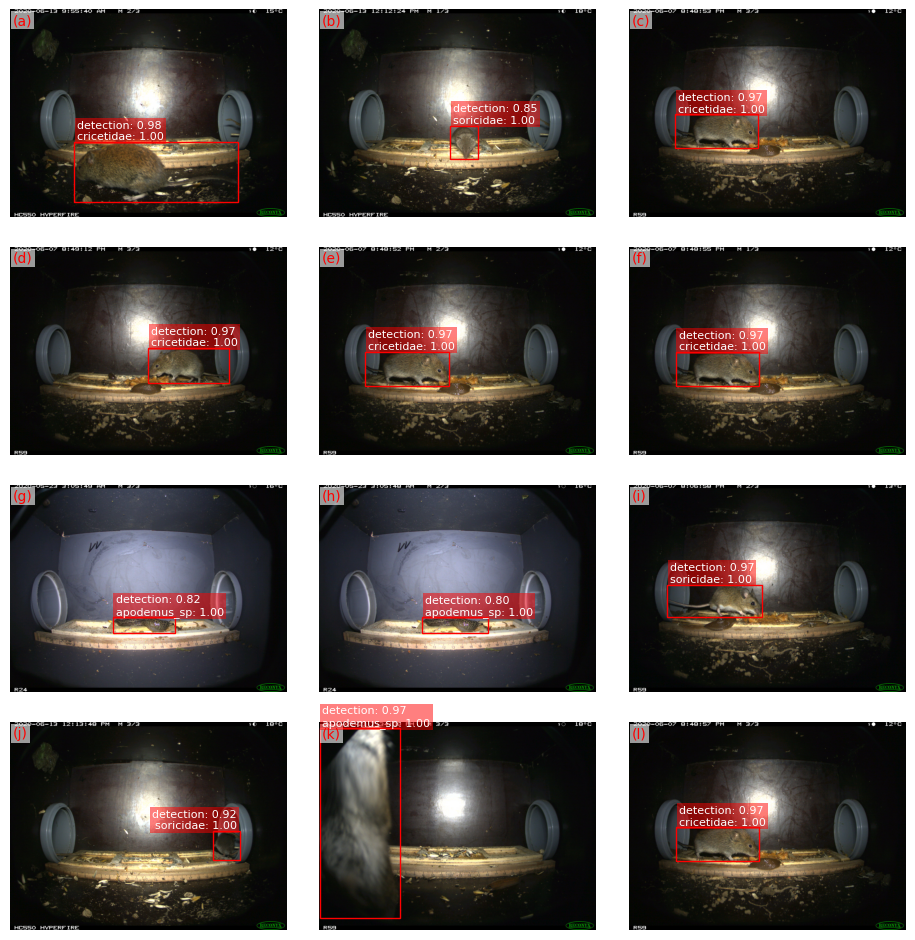

In [19]:
chunk = chunker.get_current_and_advance()
print(f"Showing chunk {chunker.current} of {len(chunker)} chunks")

plot_series_of_images(
    df=chunk, 
    dataset_path=eval.paths['dataset'],
    annotation_type='both',
    ncols=3, 
    fig_width_cm=24,
    offset_margin_conf_annotation=800
    )